In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from plotly.subplots import make_subplots  

In [3]:
import pandas as pd
df = pd.read_csv("C:/Users/mariem/projects/sales forcast/archive/walmart.csv")
df.describe()

,Store,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
count,6435.000000,6.435000e+03,6435.000000,6435.000000,6435.000000,6435.000000,6435.000000
mean,23.000000,1.046965e+06,0.069930,60.663782,3.358607,171.578394,7.999151
std,12.988182,5.643666e+05,0.255049,18.444933,0.459020,39.356712,1.875885
min,1.000000,2.099862e+05,0.000000,-2.060000,2.472000,126.064000,3.879000
25%,12.000000,5.533501e+05,0.000000,47.460000,2.933000,131.735000,6.891000
50%,23.000000,9.607460e+05,0.000000,62.670000,3.445000,182.616521,7.874000
75%,34.000000,1.420159e+06,0.000000,74.940000,3.735000,212.743293,8.622000
max,45.000000,3.818686e+06,1.000000,100.140000,4.468000,227.232807,14.313000


* Holiday_Flag : 1-The week has a Holiday 0-Fully working week 
* CPI : Customer price index (provides a general idea of how purchasing power changes due to inflation)
* Unemployment of the given store region

In [4]:
df.isna().any()

Store           False
Date            False
Weekly_Sales    False
Holiday_Flag    False
Temperature     False
Fuel_Price      False
CPI             False
Unemployment    False
dtype: bool

In [5]:
df['Date'] = pd.to_datetime(df['Date'],format='%d-%m-%Y')


# Univariante analysis

The store variable ranges from 1 to 45 and each store has about 140 data points describing each a weekly sale.

### Weekly_sales

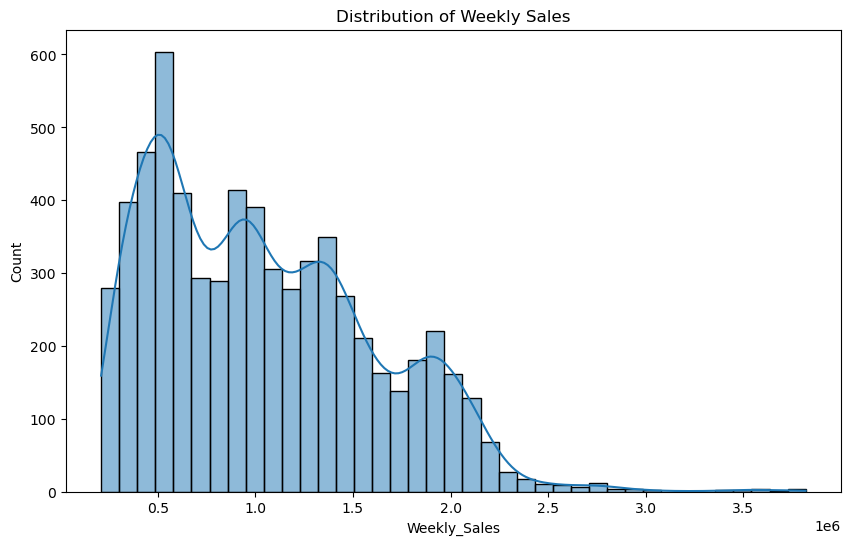

In [6]:
# Plot for 'Weekly_Sales'
plt.figure(figsize=(10, 6))
sns.histplot(df['Weekly_Sales'], kde=True)
plt.title('Distribution of Weekly Sales')
plt.show()


In [7]:
df["Weekly_Sales"].describe()

count    6.435000e+03
mean     1.046965e+06
std      5.643666e+05
min      2.099862e+05
25%      5.533501e+05
50%      9.607460e+05
75%      1.420159e+06
max      3.818686e+06
Name: Weekly_Sales, dtype: float64

* the weekly sales is not distributed around a central point but rather skewed to the left meaning there is more data points clustered towards lower sales values.
* The STD is a measure of how much the data points tend to deviate from the mean itself.in our case the sd is large this suggests that the data points are likely spread out over a wide range, even if the mean is a higher value.

#### Outliers

In [8]:
def outliers(col , df):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers_iqr = df[(df[col]< lower_bound) | (df[col] > upper_bound)]  
    plt.figure(figsize=(10, 5))
    plt.boxplot(df[col], vert=False, showfliers=True)  # Adjust 'vert' for horizontal or vertical boxplot

    # Add reference lines for IQR and outliers bounds
    plt.axvline(x=q3, color='b', linestyle='-', label='Q3')
    plt.axvline(x=q1, color='b', linestyle='-', label='Q1')
    plt.axvline(x=upper_bound, color='r', linestyle='--', label='Upper Bound')
    plt.axvline(x=lower_bound, color='r', linestyle='--', label='Lower Bound')

    # Customize plot elements and labels
    plt.xlabel(col)
    plt.title('Boxplot with IQR and Outliers')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))  # Move the legend outside the plot
    plt.show()
    return outliers_iqr , q1,q3,lower_bound,upper_bound

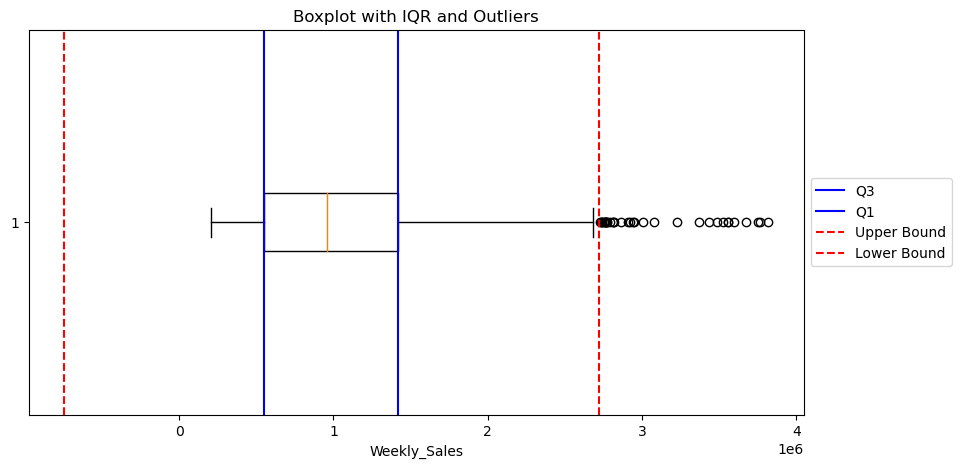

In [9]:
outliers_iqr , q1,q3,lower_bound,upper_bound = outliers('Weekly_Sales', df)


In [10]:
print((len(outliers_iqr) / len(df))*100 , " % of our weekly_sales are considered as outliers with most values above the upper bound")

0.5283605283605284  % of our weekly_sales are considered as outliers with most values above the upper bound


0.5% 

#### Time serie analysis :  Date vs Weekly_sales

<Axes: xlabel='Date'>

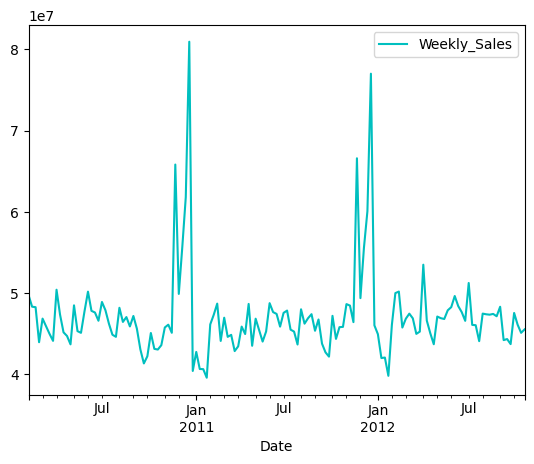

In [11]:
df.groupby("Date")[["Weekly_Sales"]].sum().plot(color='c')


* Trend : The sales figures seem to fluctuate throughout the time period, with no clear upward or downward trend.
* Seasonality: There might be a seasonal pattern to the sales, with potentially higher sales at the end of each year compared to the summer months (around July).


We are going to decompose our time serie to check our overall trend , Seasonality and residual.

In [12]:
dfx = df.groupby("Date")[["Weekly_Sales"]].sum()
decomposition = seasonal_decompose(dfx, model='additive')  # Adjust model as needed (additive or multiplicative)
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid


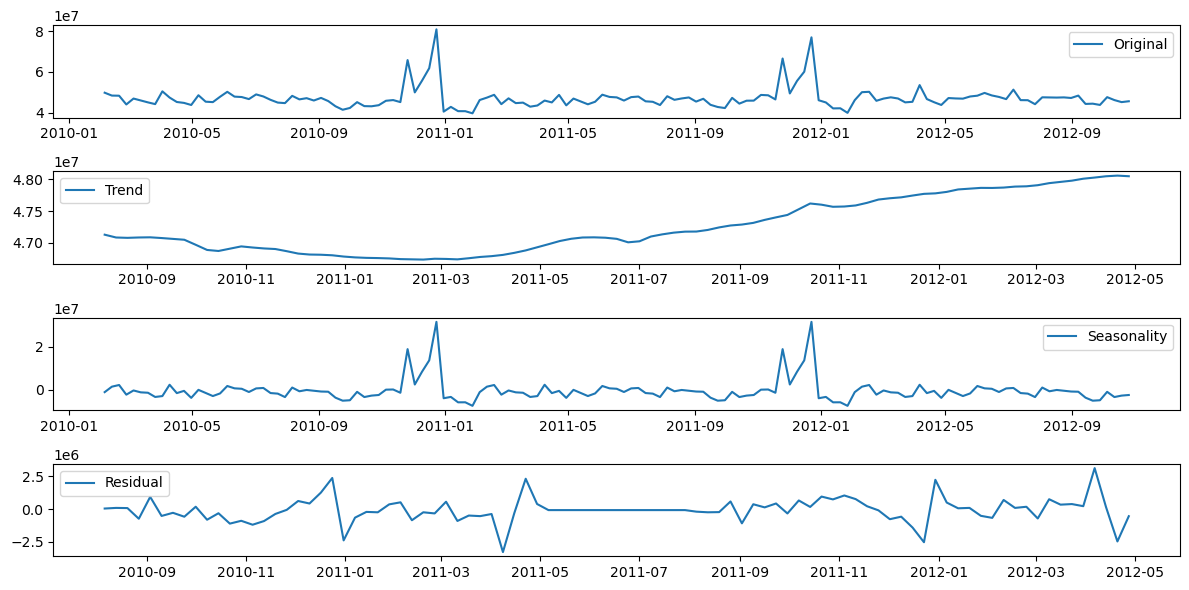

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(dfx.index, dfx, label='Original')
plt.legend()

plt.subplot(412)
plt.plot(dfx.index, trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(dfx.index, seasonality, label='Seasonality')
plt.legend()

plt.subplot(414)
plt.plot(dfx.index, residual, label='Residual')
plt.legend()

plt.tight_layout()
plt.show()


* The trend plot : This plot isolates the long-term trend in weekly sales counts, potentially indicating a gradual increase or decrease. It removes the seasonal variations and residuals to reveal the overall direction of sales. in our case there is no long_term trend in the data. the time series appears to have no overall increasing or decreasing trend, this aligns with the stationarity property. We will check stationarity
* Seasonality :  the seasonality plot clearly captures the repeating annual cycle
* Residuals : The residuals plot shows the remaining variation in the data after accounting for the trend and seasonality. Our plot is not flat meaning there is remaining unexplained fluctuations after these components are removed. thats why we are going to analyze with ACF and PACF

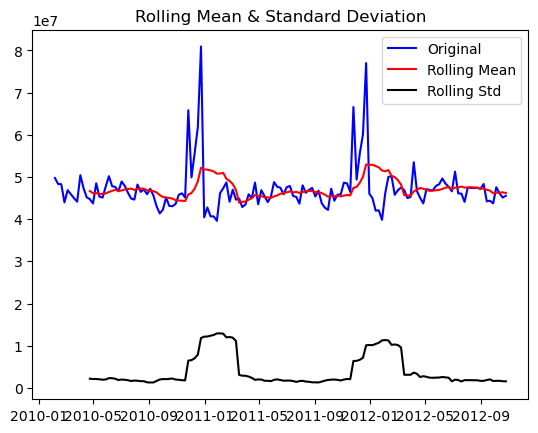

In [14]:
movingAverage = dfx.rolling(window=12).mean()
movingSTD = dfx.rolling(window=12).std()
    
    #Plot rolling statistics
plt.plot(dfx, color='blue', label='Original')
plt.plot(movingAverage, color='red', label='Rolling Mean')
plt.plot(movingSTD, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)
    


A flat or horizontal moving average suggests a lack of a clear upward or downward trend in the data. This aligns with our observation of a visually stationary series.

We are doing the Augmented Dickey-Fuller (ADF) to confirm stationarity

In [15]:

adf_result = adfuller(dfx)
  
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')
if adf_result[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")


ADF Statistic: -5.9082979571863365
p-value: 2.675979158985984e-07
Critical Values:
   1%: -3.47864788917503
   5%: -2.882721765644168
   10%: -2.578065326612056
The time series is stationary.


A stationary time series has a constant mean and variance over time. This means that the average level of the series and the variability around that average do not change.
The autocorrelations of a stationary time series do not depend on time. This means that the correlation between observations at different lags is consistent over time.


Let's isolate one year and check behaviour

In [16]:
dfx_filtered = dfx[dfx.index.year == 2011]


<Axes: xlabel='Date'>

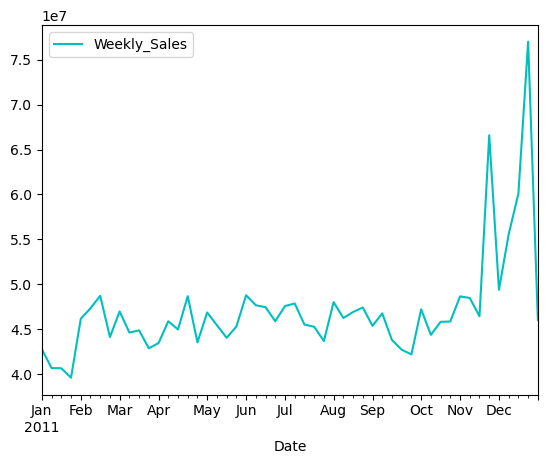

In [17]:
dfx_filtered.plot(color='c')

In [18]:
all_holidays_2011 = df[(df["Holiday_Flag"] == 1) & (df["Date"].dt.year == 2011)]  
all_rows_match = all_holidays_2011 
all_rows_match.Date.unique()

array(['2011-02-11T00:00:00.000000000', '2011-09-09T00:00:00.000000000',
       '2011-11-25T00:00:00.000000000', '2011-12-30T00:00:00.000000000'],
      dtype='datetime64[ns]')

Okay so in this year we have a peak in sales around Feb 11 which is due to super bowl, around 9 sep because of labour Day , 25 Nov we have thanksgiving, and after that its christmas and new years.

This shows clearly how sales sky rocket in end of each year.

We will analyse ACF and PACF to detect patterns and dependencies within time serie
* ACF: Measures the correlation between a time series and itself at different lags (time differences). This reveals how much past values (lagged values) influence the current value.
* PACF: Similar to ACF, but it removes the influence of correlations at previous lags. This helps isolate the unique effect of each lag on the current value.

c:\Users\mariem\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


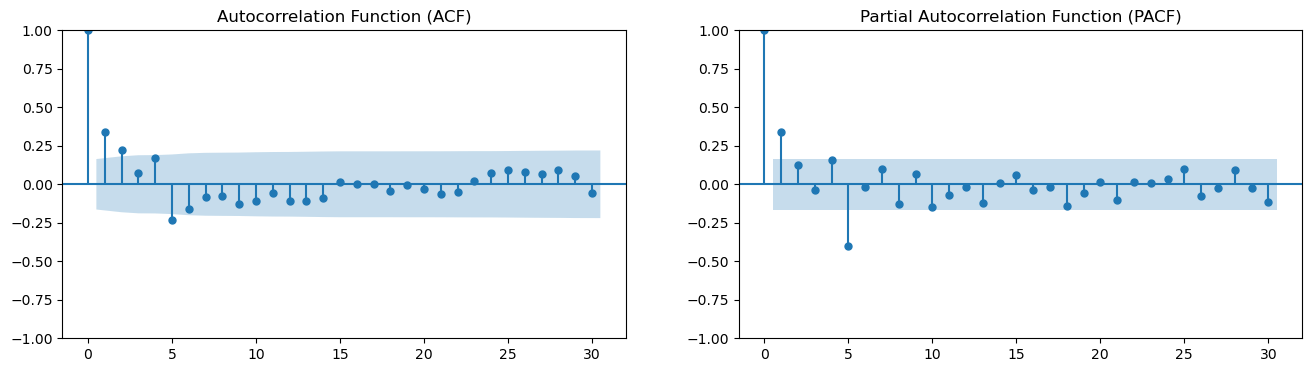

In [19]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# ACF plot
plot_acf(dfx, lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(dfx, lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.show()

 * ACF: a high postive acf value in the lag 2 and 3 this indicates that the current value(2 and 3) is positively correlated with the value at that lag (1 and 2). In simpler terms, past values (lagged values) can be informative for predicting the current value.
 we also have a high negative value in lag 5 which means that lag might help predict the opposite of the current value.
 * PACF : a high positive PACF value at a specific lag , here lag 2 and 6  indicates a significant correlation between the current value (t) and the value at that lag (t-k).

### Temperature

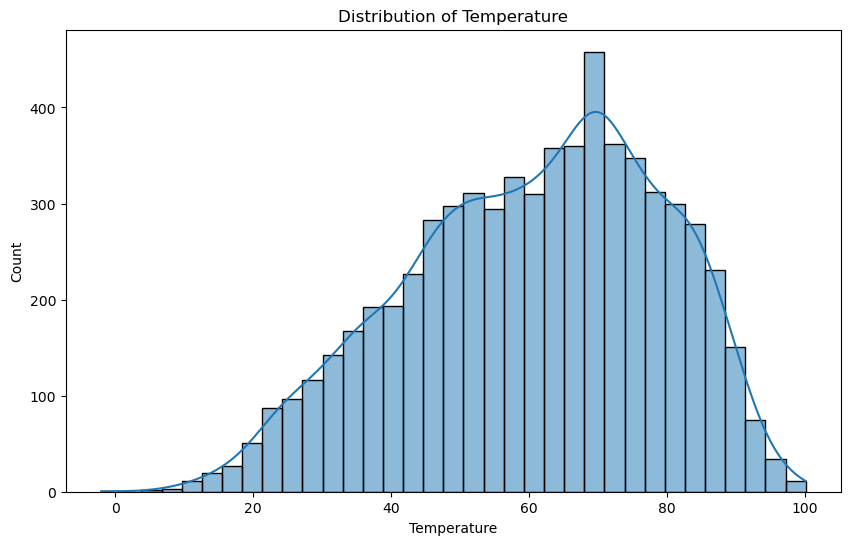

In [20]:
# Plot for 'Temperature'
plt.figure(figsize=(10, 6))
sns.histplot(df['Temperature'], kde=True)
plt.title('Distribution of Temperature')
plt.show()


* Right-skewed:  The data is clustered more towards the left side of the graph (lower Temperature) and has a longer tail extending towards the right side (higher Temperature).   
* A standard deviation of 18.44 compared to a mean of 60 suggests a relatively tight distribution of temperatures around the average. Most temperatures likely fall within a range of roughly 41.56 (60 - 18.44) to 78.44 (60 + 18.44).

#### Outliers

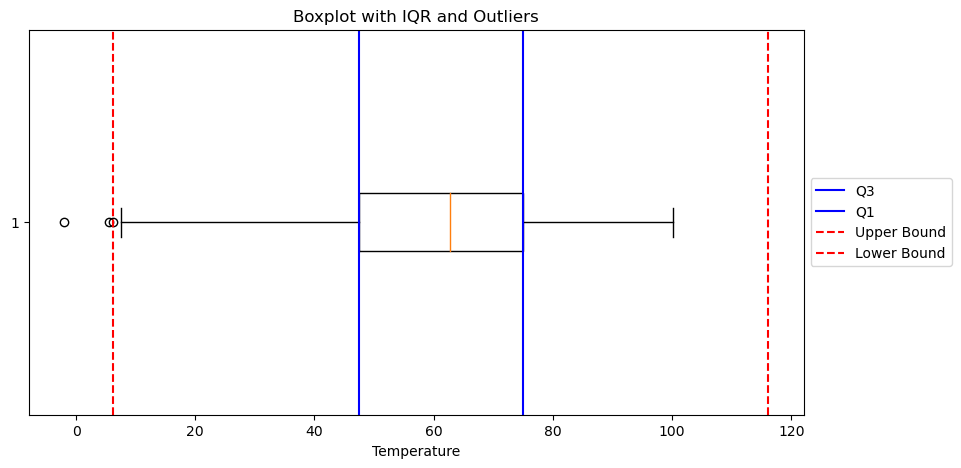

0.046620046620046623 % of our Temperature are considered as outliers with most values under the lower bound


In [21]:
outliers_iqr , q1,q3,lower_bound,upper_bound = outliers('Temperature', df)
print((len(outliers_iqr) / len(df))*100 , "% of our Temperature are considered as outliers with most values under the lower bound")

### Fuel price

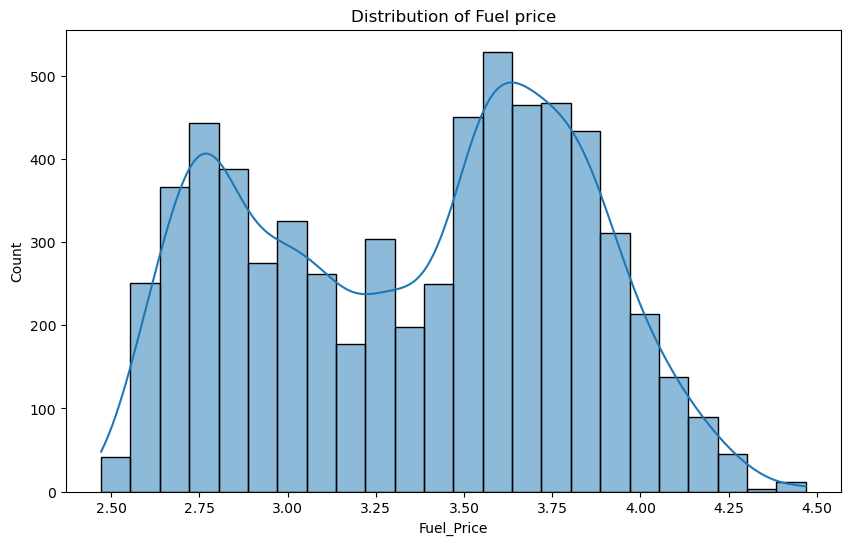

In [22]:
# Plot for 'Fuel price'
plt.figure(figsize=(10, 6))
sns.histplot(df['Fuel_Price'], kde=True)
plt.title('Distribution of Fuel price')
plt.show()


* Bimodal distribution : The histogram appears to have two peaks, one around 3.6 and another around 2.75. This suggests there are two distinct groups of prices the data has two clusters 

#### Outliers

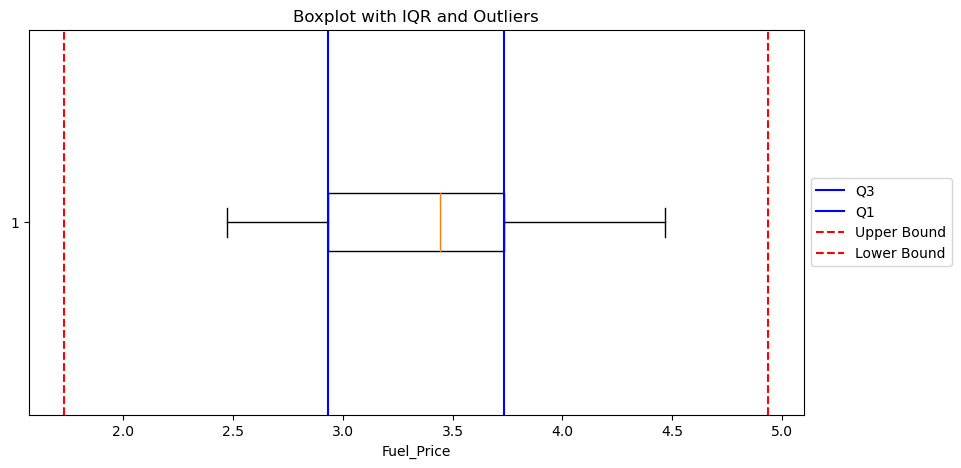

0.0 % of our Fuel_Price are considered as outliers 


In [23]:
outliers_iqr , q1,q3,lower_bound,upper_bound = outliers('Fuel_Price', df)
print((len(outliers_iqr) / len(df)) , "% of our Fuel_Price are considered as outliers ")

<Axes: xlabel='Date'>

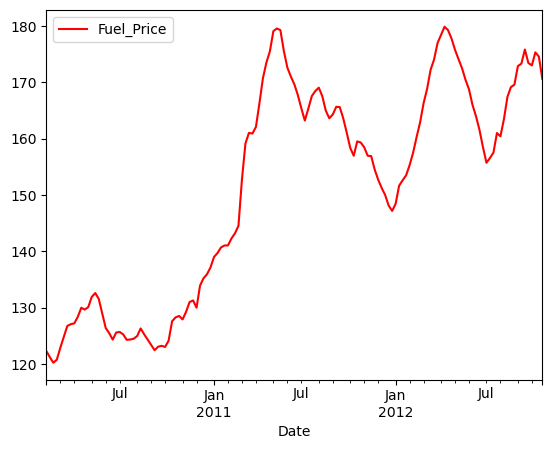

In [24]:
df.groupby("Date")[["Fuel_Price"]].sum().plot(color='r')


Here we have different behaviour, when weekly_sales peaks at the end of the year , the fuel price drops. This can be due to:
*  Refineries typically transition from producing summer-blend gasoline (designed for higher temperatures and emissions regulations) to winter-blend gasoline (cheaper to produce) around September or October. so they sell off remaining summer-blend inventory and introduce the cheaper winter-blend. 
* As days become shorter and colder, people tend to drive less. This decrease in demand, coupled with increased refinery production (to meet winter heating oil needs), can contribute to a temporary price decline.

### CPI

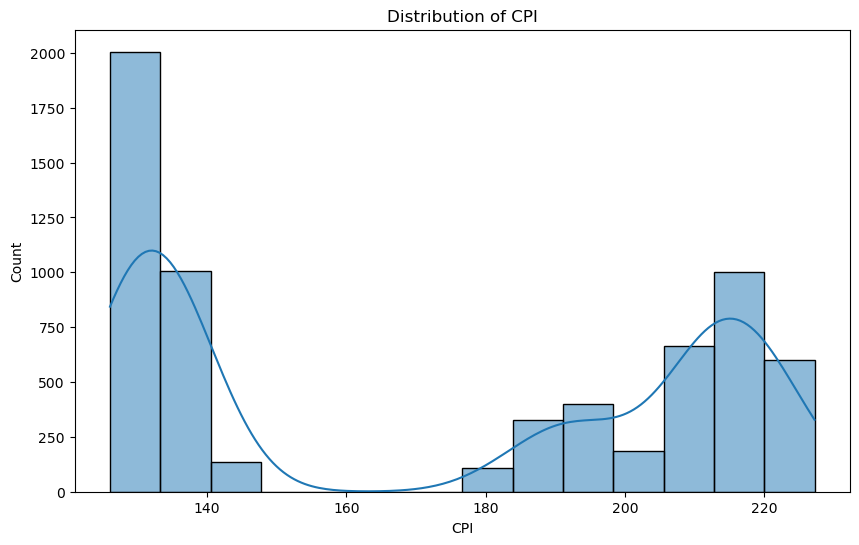

In [25]:
# Plot for 'CPI'
plt.figure(figsize=(10, 6))
sns.histplot(df['CPI'], kde=True)
plt.title('Distribution of CPI')
plt.show()

* Bimodal distribution : The histogram appears to have two peaks, one around 135 and another around 215. This suggests there are two distinct groups of cpi the data has two clusters 
the std is 39 

#### Outliers

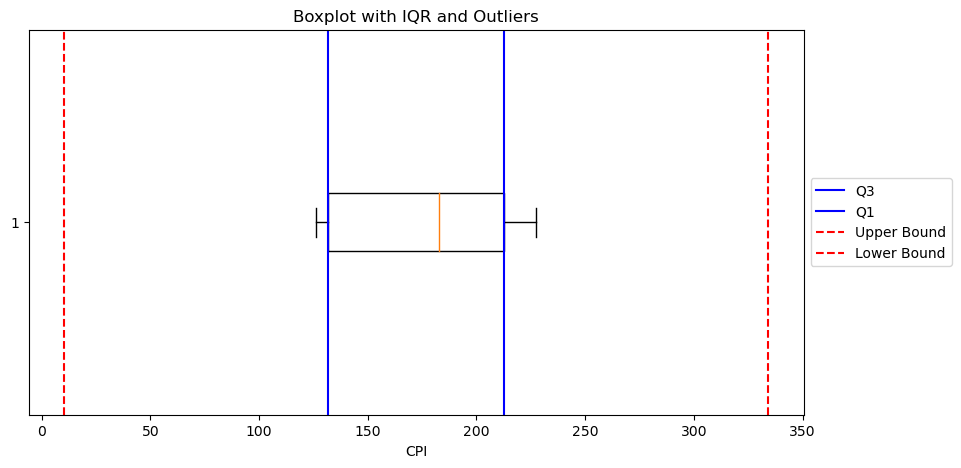

0.0 % of our cpi are considered as outliers 


In [26]:
outliers_iqr , q1,q3,lower_bound,upper_bound = outliers('CPI', df)
print((len(outliers_iqr) / len(df))*100 , "% of our cpi are considered as outliers ")

<Axes: xlabel='Date'>

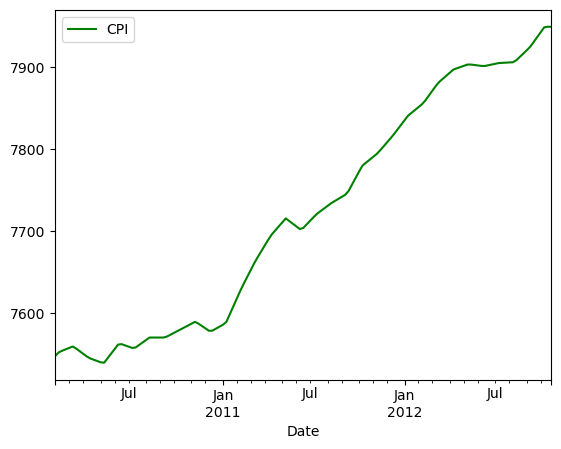

In [27]:
dfp= df.groupby("Date")[["CPI"]].sum()
dfp.plot(color='g')

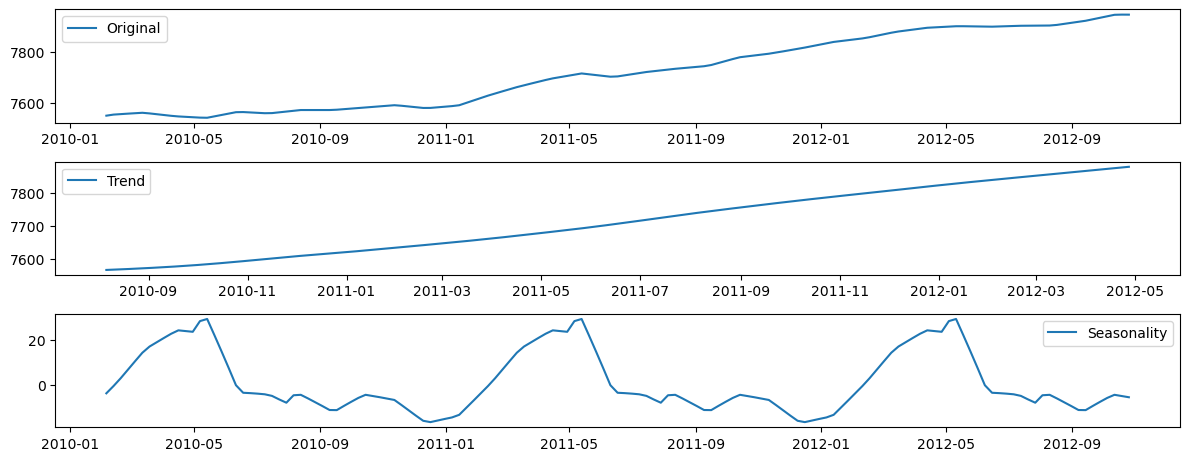

In [28]:
decomposition = seasonal_decompose(dfp, model='additive')  # Adjust model as needed (additive or multiplicative)
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 6))
plt.subplot(411)
plt.plot(dfp.index, dfp, label='Original')
plt.legend()

plt.subplot(412)
plt.plot(dfp.index, trend, label='Trend')
plt.legend()

plt.subplot(413)
plt.plot(dfp.index, seasonality, label='Seasonality')
plt.legend()


plt.tight_layout()
plt.show()

The seasonality is not clear in the original plot so we decomposed the time serie :
* The original data plot shows a clear increasing trend over time. This suggests that the absolute value of the seasonal fluctuations might remain relatively constant even as the overall level of the data increases. The increase is due to inflation
* In the seasonality plot, the peaks and dips appear to have a consistent magnitude throughout the cycle, even though the underlying trend in the original data is increasing.
the peaks are around christmas and end of year which is logical,higher prices due to seasonal holiday demand.

### Unemployement

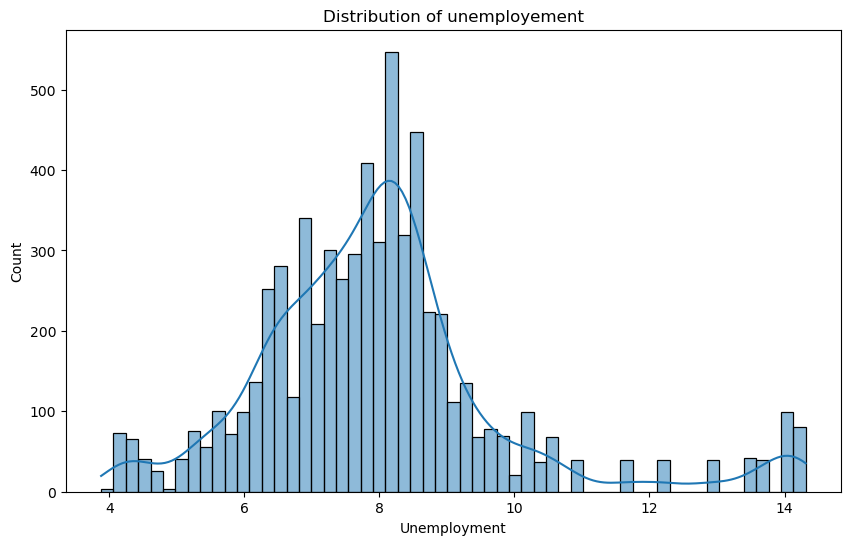

In [29]:
# Plot for 'unemployement'
plt.figure(figsize=(10, 6))
sns.histplot(df['Unemployment'], kde=True)
plt.title('Distribution of unemployement')
plt.show()

* the unemployement is not distributed around a central point but rather slightly skewed to the left meaning there is more data points clustered towards lower unemployement  rated.
* The SD is a measure of how much the data points tend to deviate from the mean itself.in our case the sd is low this suggests that the data points are likely spread out over a tight range.

#### Outliers

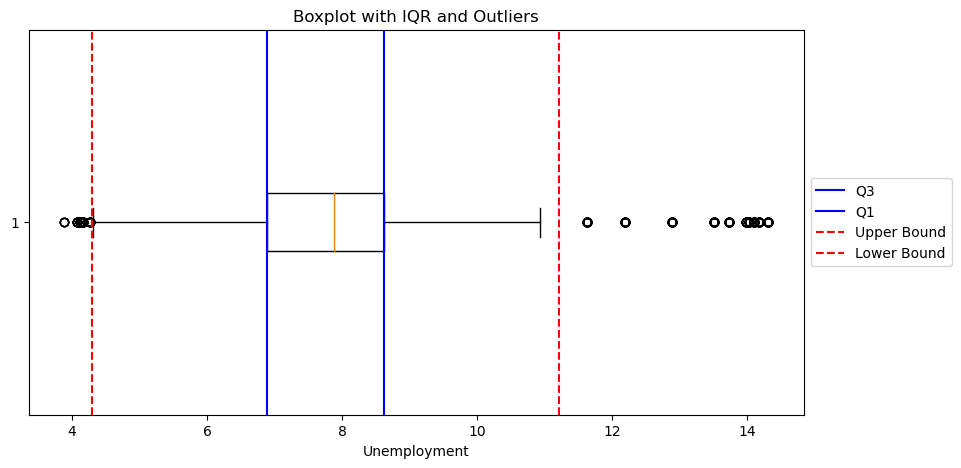

7.474747474747474 % of our Unemployment are considered as outliers with some values exceeding the upper bound and others the lower 


In [30]:
outliers_iqr , q1,q3,lower_bound,upper_bound = outliers('Unemployment', df)
print((len(outliers_iqr) / len(df)) *100 , "% of our Unemployment are considered as outliers with some values exceeding the upper bound and others the lower ")

# Multivariante analysis

* Dependent variable : Weekly_sales
* Independent variable : Temperature , fuel_price,cpi,unemployement and holiday_flag

Correlation test between Dependent variable and other independent variables.

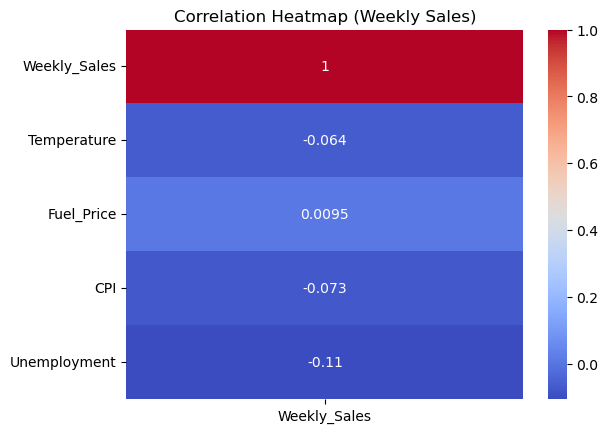

In [31]:
dff = df[['Weekly_Sales' , 'Temperature' , 'Fuel_Price' , 'CPI' ,'Unemployment']]
filtered_corr = dff.corr(method='pearson')[['Weekly_Sales']]  # Use Pearson's correlation

# Create a heatmap with Seaborn (using absolute correlation)
sns.heatmap(filtered_corr, annot=True, cmap='coolwarm')  # Colormap for positive/negative correlations

# Customize the heatmap (optional)
plt.title("Correlation Heatmap (Weekly Sales)")
plt.show()

In here we didn't take into account the holiday flag since its a categorical variable. its values are binary so the pearson method in calculating correlation is not suitable. We will be using the Point bisearial method which is specifically used to calculate correlation coefficient to assess the linear relationship between a binary variable and a continuous variable. 

In [32]:
from scipy.stats import pointbiserialr

correlation = pointbiserialr(df['Holiday_Flag'], df['Weekly_Sales'])

# Print the correlation
print("Point-Biserial Correlation between Weekly Sales and Holiday Flag:", correlation)

Point-Biserial Correlation between Weekly Sales and Holiday Flag: SignificanceResult(statistic=0.03689096801041451, pvalue=0.00307869926384778)


* Null Hypothesis (H0): There is no statistically significant association between the binary variable (Holiday Flag in your case) and the continuous variable (Weekly Sales).

* Alternative Hypothesis (H1): There is a statistically significant association between the binary variable (Holiday Flag) and the continuous variable (Weekly Sales). 

p_value = 0.003 < 0.05 --> Reject the Null Hypothesis: The null hypothesis in this case would be that there's no association between Holiday Flag and Weekly Sales. Since the p-value is very low (less than 0.05, which is a common threshold), we reject this hypothesis.
* Statistically Significant Association: There's a statistically significant association between Holiday Flag and Weekly Sales. This means that, on average, weekly sales tend to be different during holidays compared to non-holidays.

////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

Uncover hidden patterns and relationships between variables. Since we have one dependent variable we will use  Multiple Regression Analysis instead of MANOVA.This technique allows us to model the relationship between a dependent variable (the variable you're trying to explain : Weekly_sales) and multiple independent variables (the variables you believe might influence the dependent variable : the rest).

our equation is : y = a + b 1×1+ b2×2+……+ bkxk , where x1, x2, ….xk are the k independent variables and y is the dependent variable.

In [59]:
#Changing date to numerical counting from minimum date in our data.
reference_date = pd.to_datetime('2010-02-05')
df['days'] = (df['Date'] - reference_date).dt.days


In [61]:
dep = df[["Weekly_Sales"]]
indep = df[['days' , 'Holiday_Flag', 'Temperature','Fuel_Price', 'CPI', 'Unemployment']]

In [66]:
import statsmodels.api as sm

# Wrap the scikit-learn model with statsmodels
model = sm.OLS(dep, indep)

# Fit the model again (necessary for statsmodels)
results = model.fit()

# Print the summary showing coefficients, p-values, and other statistics
print(results.summary())


                                 OLS Regression Results                                
Dep. Variable:           Weekly_Sales   R-squared (uncentered):                   0.770
Model:                            OLS   Adj. R-squared (uncentered):              0.770
Method:                 Least Squares   F-statistic:                              3585.
Date:                Sat, 20 Jul 2024   Prob (F-statistic):                        0.00
Time:                        14:39:46   Log-Likelihood:                         -94422.
No. Observations:                6435   AIC:                                  1.889e+05
Df Residuals:                    6429   BIC:                                  1.889e+05
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

CPI has the strongest positive impact followed by Temperature and days with the negative impact.\
p-values for each coefficient.
* H0 statistically significant relationship between the variable and the dependent variable if A value less than 0.05 (generally).
* H1 statistically insignificant relationship between the variable and the dependent variable if A value more than 0.05 (generally).
In this example : all your variables except "Temperature" have p-values less than 0.05. This suggests statistically significant relationships between those variables and Weekly_Sales.\
"Temperature" has a p-value of 0.212, which is >0.05 . This means the relationship between temperature and Weekly_Sales might not be statistically significant in your model.\
R-squared: This value (0.770) indicates that your model explains 77% of the variance in Weekly_Sales.

# Summarize Key Findings:
* the weekly sales's destribution is skewed to the left meaning there is more data points clustered towards lower sales values.
* There isn't much outliers in all variables.
* The time serie's decomposition shows no trend but an obvious seasonality with a repeating annual cycle.
* There is correlation between Weekly sales and all other variables.
* Linear regression shows statiscally significant relationship between Weekly sales and all other variables except Temperature.
ps : temperature vs weekly sales : high negative correlation but no statistical significance in the linear model. This may mean that the relationship between these variables is not linear. OR The other variables could be capturing the main effect on sales, leaving little room for temperature's influence to show statistically significant results.
